## Importaciones

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime 
import math

from statsmodels.tsa.seasonal import seasonal_decompose #descomposición de una serie temporal
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

#from ipywidgets import interact
#import plotly.express as px
#import ipywidgets as widgets

#from sklearn.feature_selection import SelectFromModel
#from sodapy import Socrata

import itertools
import time

### Definición de funciones


In [6]:
#Definición de funciones

#Formula para evaluar modelos:
def get_error_percentage(real_it, predicted_it):
    #cuanto más cerca del 0 mejor
    #print("get_error_percentage() method was called.")
    rmse = math.sqrt(mean_squared_error(real_it, 
    predicted_it))
    error_percentage = rmse / np.average(real_it)
    return error_percentage

In [7]:
def analisis_adfuller(ts):
    if adfuller(ts)[1]>0.05:
        return f'Rechazamos la Ho porque {adfuller(ts)[1]} es mayor que 0.05. Por tanto, la señal es estacionaria'
    else:
        return f'La señal no es estacionaria'

### Dataset

In [8]:
df = pd.read_csv('output/Enfer.csv', sep=',',encoding='latin1',decimal=".")

In [9]:
#comprobamos los datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    230 non-null    int64  
 1   COLECTIVO                230 non-null    object 
 2   mes                      230 non-null    int64  
 3   año                      230 non-null    int64  
 4   Festivos_intersemanales  230 non-null    int64  
 5   Plantilla                230 non-null    float64
 6   Plantilla_de_baja        230 non-null    float64
 7   date                     230 non-null    object 
 8   casos_covid              230 non-null    float64
 9   busquedas_google         230 non-null    float64
 10  cambio_normativa         230 non-null    int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 19.9+ KB


In [10]:
df['date'] = pd.to_datetime(df['date'])

In [11]:
#Elimino columnas no relevantes para análisis de series temporales
df.drop(['index','COLECTIVO','mes','año'],axis=1,inplace=True)

## Feature importance

In [12]:
#definimos X e y:
X=df.drop(['Plantilla_de_baja','date'],axis=1)
y=df['Plantilla_de_baja']

In [13]:
rf=RandomForestRegressor(n_estimators=100)
rf.fit(X,y)
rf.feature_importances_

array([0.02054784, 0.35264434, 0.41410591, 0.12992745, 0.08277447])

In [14]:
pd.Series(rf.feature_importances_,index=X.columns.to_list())

Festivos_intersemanales    0.020548
Plantilla                  0.352644
casos_covid                0.414106
busquedas_google           0.129927
cambio_normativa           0.082774
dtype: float64

El feature importance de Random Forest sugiere sólo considerar las variables 'Plantilla', 'Casos_covid' y 'Busquedas_google'

## Análisis de series temporales

### Visualizacion componentes de seasonal descompose

In [17]:
ts=df.set_index('date')
ts_it=ts[['Plantilla_de_baja']]
ts_covid=ts[['casos_covid']][-24:] #desde marzo 2020
ts_plantilla=ts[['Plantilla']]
ts_google=ts[['busquedas_google']][33:] #desde octubre de 2005

'Rechazamos la Ho porque 0.21938649729407073 es mayor que 0.05. Por tanto, la señal es estacionaria'

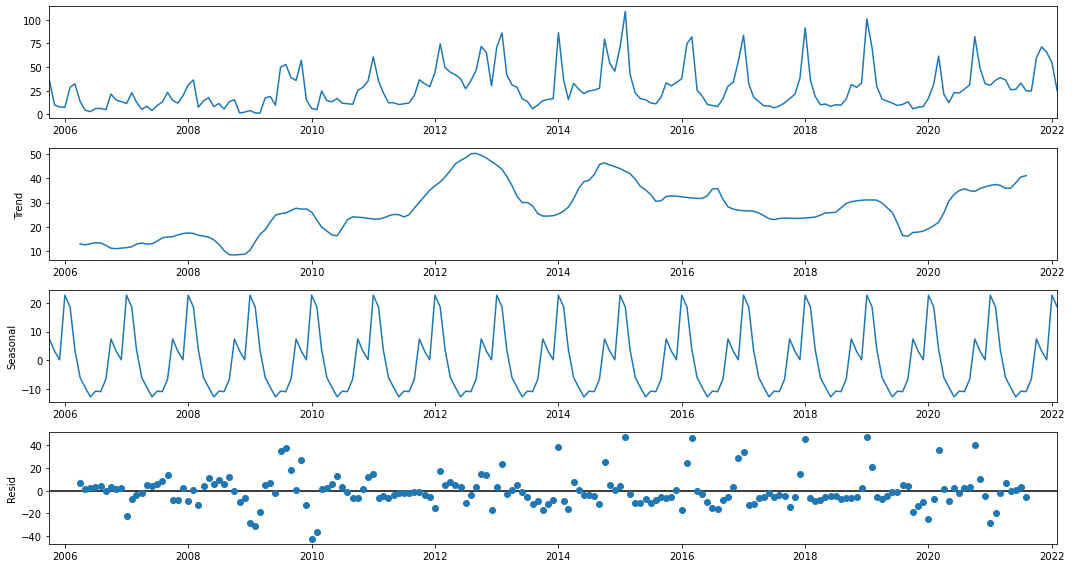

In [18]:
#Analizamos estacionalidad de busquedas en google
plt.rcParams['figure.figsize']=(15,8)

decomposition=seasonal_decompose(ts_google)
_=decomposition.plot()

analisis_adfuller(ts_google)


'Rechazamos la Ho porque 0.17717225483783056 es mayor que 0.05. Por tanto, la señal es estacionaria'

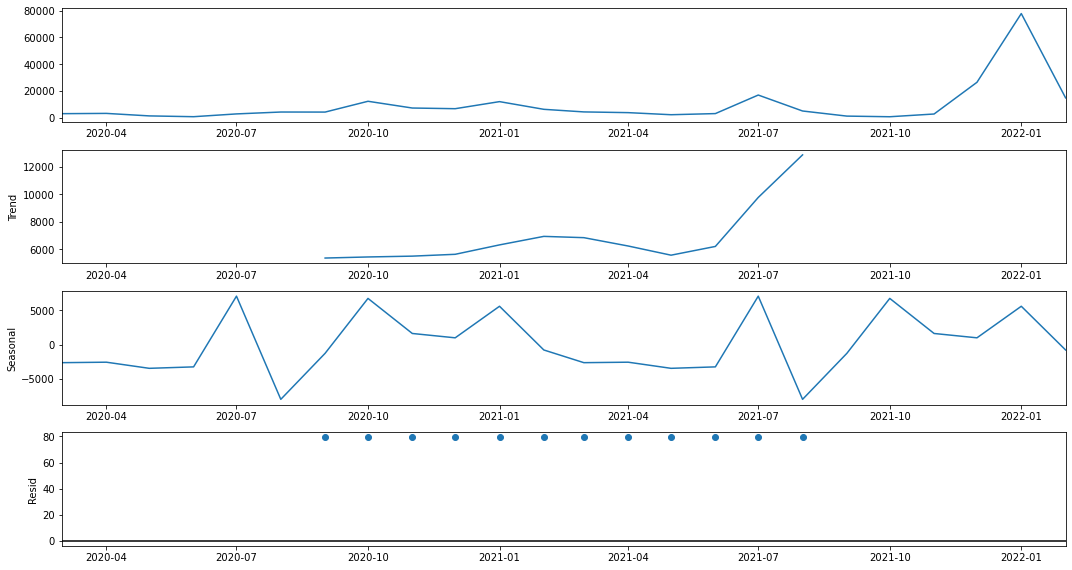

In [19]:
#Analizamos estacionalidad de casos covid
decomposition=seasonal_decompose(ts_covid)
_=decomposition.plot()

analisis_adfuller(ts_covid)

'Rechazamos la Ho porque 0.9765228601891162 es mayor que 0.05. Por tanto, la señal es estacionaria'

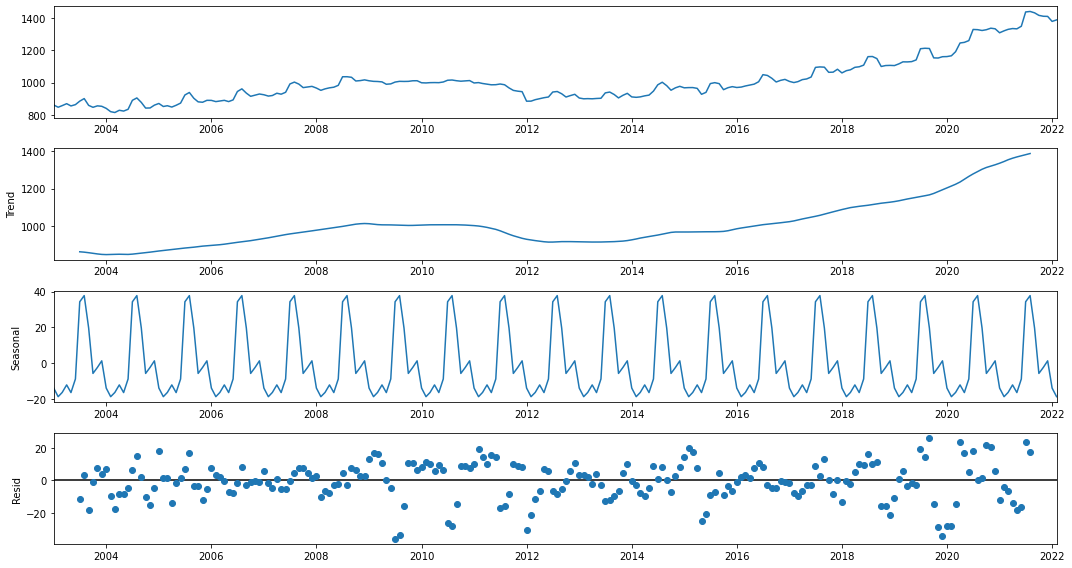

In [20]:
#Analizamos estacionalidad de busquedas en plantilla
decomposition=seasonal_decompose(ts_plantilla)
_=decomposition.plot()

analisis_adfuller(ts_plantilla)

'Rechazamos la Ho porque 0.26546786156435415 es mayor que 0.05. Por tanto, la señal es estacionaria'

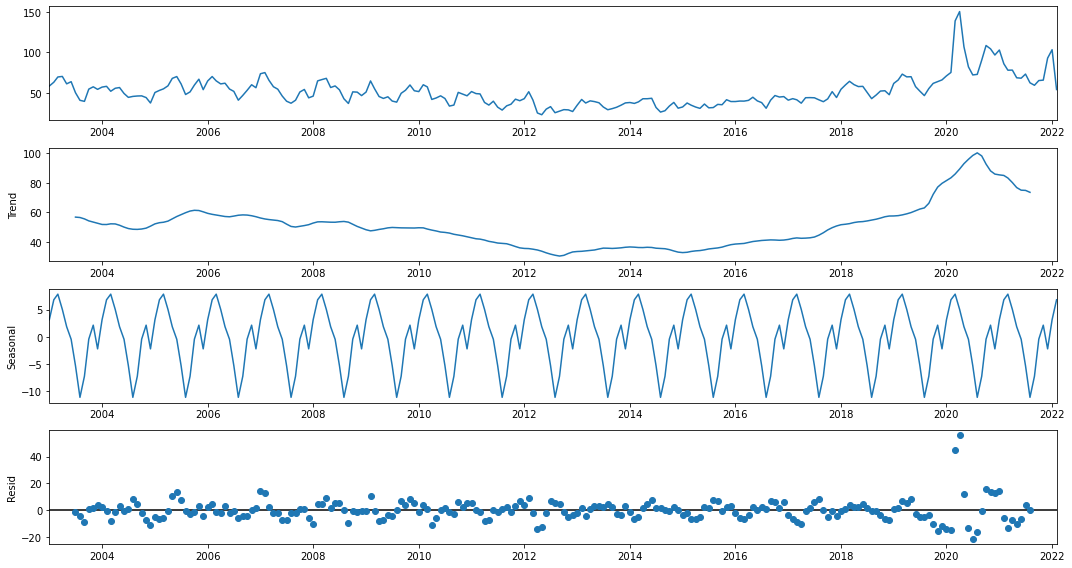

In [21]:
#Analizamos estacionalidad de busquedas en plantilla de it
decomposition=seasonal_decompose(ts_it)
_=decomposition.plot()

analisis_adfuller(ts_it)

### Funciones ACF/PACF

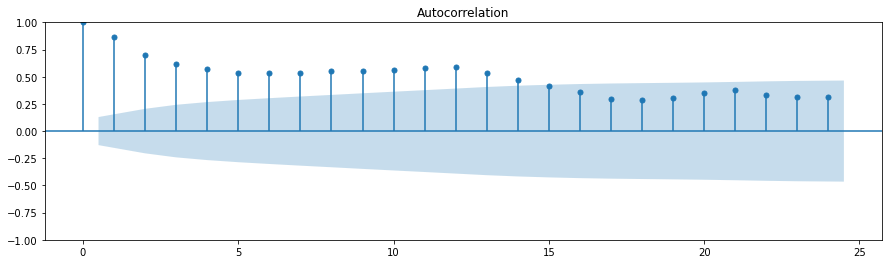

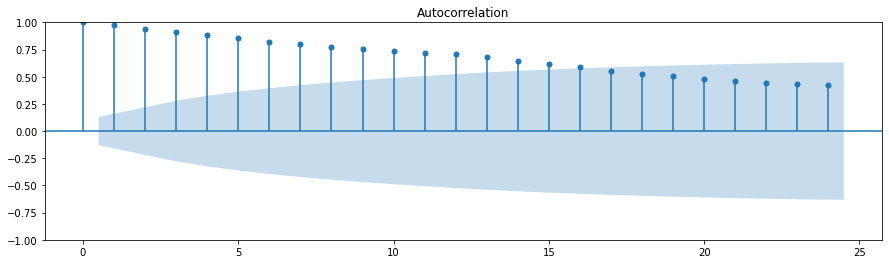

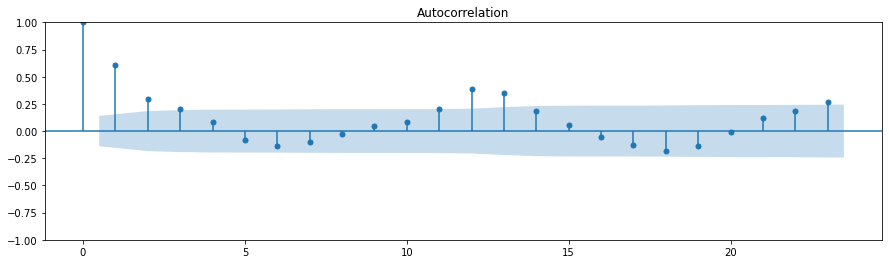

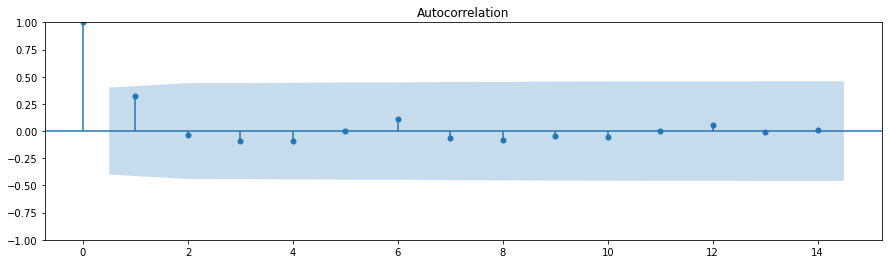

In [22]:
plt.rcParams['figure.figsize']=(15,4)
for i in [ts_it,ts_plantilla,ts_google,ts_covid]:
    _=plot_acf(i)

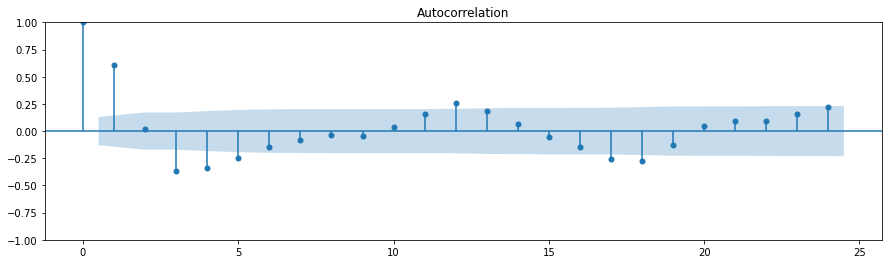

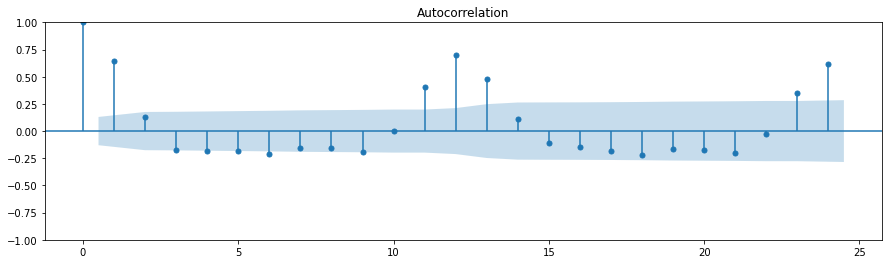

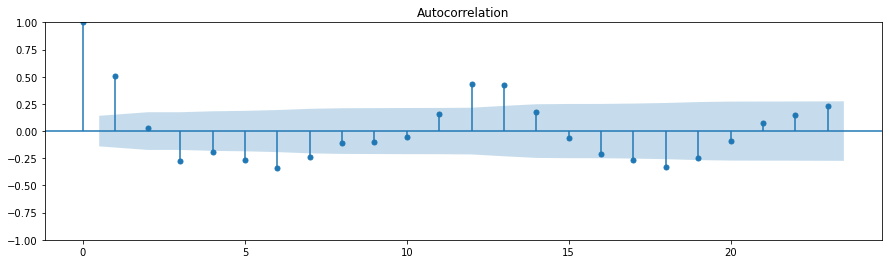

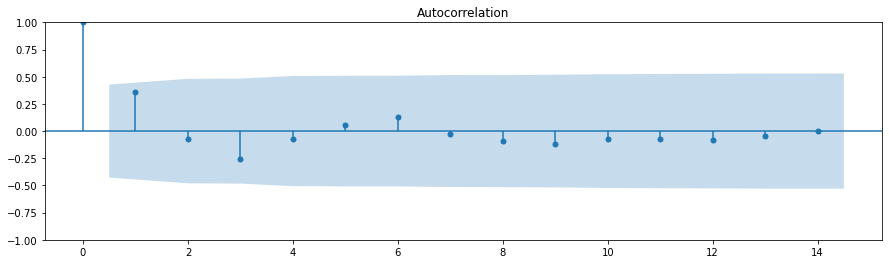

In [23]:
#diferenciación de 3 para ver más clara la estacionalidad
plt.rcParams['figure.figsize']=(15,4)
for i in [ts_it,ts_plantilla,ts_google,ts_covid]:
    _=plot_acf(i.diff(3).dropna())

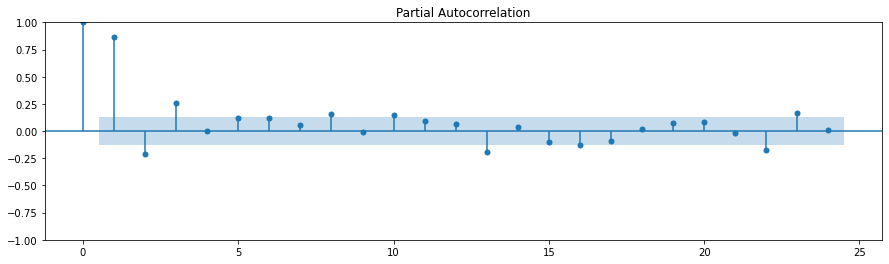

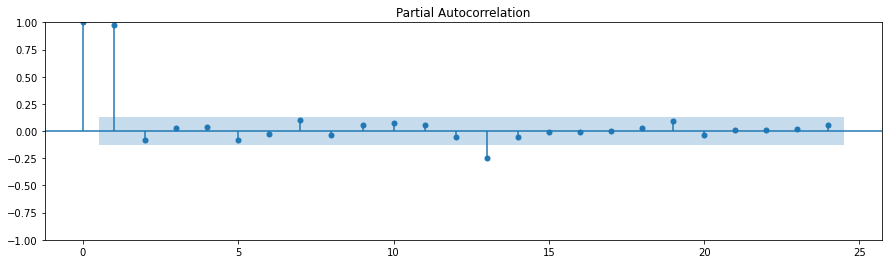

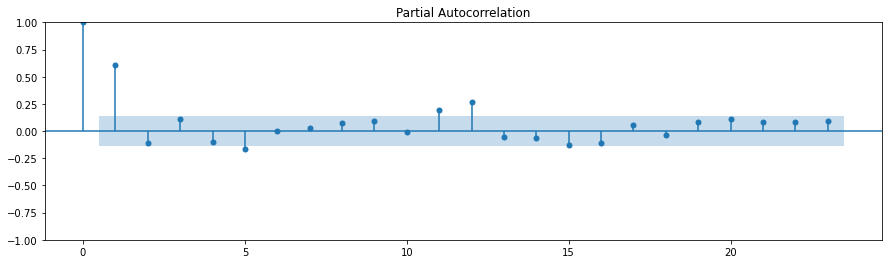

In [72]:
plt.rcParams['figure.figsize']=(15,4) #No se puede con ts_covid pq no hay suficientes muestras
for i in [ts_it,ts_plantilla,ts_google]:
    _=plot_pacf(i, method='ywm')

### Conclusiones
* Se observa estacionaridad de 12 meses de la variable plantilla de it.
* Se observa estacionaridad de 12 meses de la variable plantilla.
* Se observa estacionaridad de 12 meses de la variable búsquedas google.
* No se observa estacionaridad en la variable casos covid

## Selección de modelo

### GridSearch con Autoarima

In [25]:

def GS_arima(exogenas,ranking):
    if len(exogenas)==0:
        model_arima=auto_arima(ts[['Plantilla_de_baja']], trace=False)
        #Obtenemos modelo SARIMAX con parámetros obtenidos
        params = model_arima.order 
        sparams = model_arima.order+(12,)
        smodel = SARIMAX(ts[['Plantilla_de_baja']], 
                order=params,
                seasonal_order=sparams, 
                freq='MS'
                )
        results=smodel.fit(maxiter=100)
    else:
        model_arima=auto_arima(ts[['Plantilla_de_baja']],exog=ts[exogenas], trace=False)
        #Obtenemos modelo SARIMAX con parámetros obtenidos
        params = model_arima.order
        sparams = model_arima.order+(12,) 

        smodel = SARIMAX(ts[['Plantilla_de_baja']],
                    exog=ts[exogenas],
                    order=params,
                    seasonal_order=sparams, 
                    freq='MS'
                    )

        results=smodel.fit(maxiter=100)

    #intentamos hacer una prediccion de los datos  a partir de nuestro modelo
    y_pred=results.get_prediction(start=ts.index[1].strftime("%Y-%m-%d"),end=ts.index[-1].strftime("%Y-%m-%d")).predicted_mean

    #Evaluamos modelo Sarimax:
    porc_error_SARIMAX=get_error_percentage(ts[['Plantilla_de_baja']][1:],y_pred)
    tuple=(len(exogenas),exogenas,porc_error_SARIMAX,sparams)
    return ranking.append(tuple)



In [26]:
grid_exogenas=[]


stuff = ts.drop('Plantilla_de_baja',axis=1).columns.to_list()
for L in range(0, len(stuff)+1):
    for subset in itertools.combinations(stuff, L):
        grid_exogenas.append(list(subset))
    
len(grid_exogenas)

32

#### GridSearch con Autoarima con variable COVID

In [27]:
grid_exogenas_con_covid=[]
for i in grid_exogenas:
    if 'casos_covid' in i:
        grid_exogenas_con_covid.append(i)
    else:
        pass
len(grid_exogenas_con_covid)

16

In [28]:
%%time
#Grid search total

ranking_modelos_con_covid=[]

for i in grid_exogenas_con_covid:
    GS_arima(i,ranking=ranking_modelos_con_covid)

ranking_arima_covid=pd.DataFrame(ranking_modelos_con_covid, columns =['Num_exógenas', 'Exógenas', 'Score','Sparams']).sort_values(by='Score')
ranking_arima_covid

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py

Wall time: 19min 19s


,Num_exógenas,Exógenas,Score,Sparams
15,5,"[Festivos_intersemanales, Plantilla, casos_cov...",0.141287,"(1, 1, 5, 12)"
14,4,"[Plantilla, casos_covid, busquedas_google, cam...",0.142336,"(1, 1, 5, 12)"
2,2,"[Plantilla, casos_covid]",0.143232,"(1, 1, 5, 12)"
12,4,"[Festivos_intersemanales, Plantilla, casos_cov...",0.143337,"(1, 1, 5, 12)"
9,3,"[Plantilla, casos_covid, cambio_normativa]",0.143855,"(1, 1, 5, 12)"
5,3,"[Festivos_intersemanales, Plantilla, casos_covid]",0.143971,"(1, 1, 5, 12)"
13,4,"[Festivos_intersemanales, casos_covid, busqued...",0.147153,"(1, 1, 5, 12)"
3,2,"[casos_covid, busquedas_google]",0.147301,"(1, 1, 5, 12)"
6,3,"[Festivos_intersemanales, casos_covid, busqued...",0.147482,"(1, 1, 5, 12)"
11,4,"[Festivos_intersemanales, Plantilla, casos_cov...",0.147503,"(1, 1, 5, 12)"


In [29]:
best_exog_arima_con_covid=ranking_arima_covid['Exógenas'].iloc[[0]].to_list()[0]
best_score_arima_con_covid=ranking_arima_covid['Score'].iloc[[0]].to_list()[0]
parametros_arima_con_covid=ranking_arima_covid['Sparams'].iloc[[0]].to_list()[0]
f"El mejor modelo de ARIMA con variable COVID tiene como variables exógenas a {best_exog_arima_con_covid} con un error de {best_score_arima_con_covid}"

"El mejor modelo de ARIMA con variable COVID tiene como variables exógenas a ['Festivos_intersemanales', 'Plantilla', 'casos_covid', 'busquedas_google', 'cambio_normativa'] con un error de 0.14128715351345864"

#### GridSearch con Autoarima sin COVID

In [30]:
grid_exogenas_sin_covid=[]
for i in grid_exogenas:
    if 'casos_covid' in i:
        pass
    else:
        grid_exogenas_sin_covid.append(i)
len(grid_exogenas_sin_covid)

16

In [31]:

%%time
#Grid search sin casos covid:
ranking_modelos_sin_covid=[]

for i in grid_exogenas_sin_covid:
    GS_arima(i,ranking=ranking_modelos_sin_covid)

ranking_arima_sin_covid=pd.DataFrame(ranking_modelos_sin_covid, columns =['Num_exógenas', 'Exógenas', 'Score','Sparams']).sort_values(by='Score')
ranking_arima_sin_covid

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\base\model.py:604: Co

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueW

Wall time: 20min 58s


,Num_exógenas,Exógenas,Score,Sparams
11,3,"[Festivos_intersemanales, Plantilla, busquedas...",0.148649,"(1, 1, 5, 12)"
15,4,"[Festivos_intersemanales, Plantilla, busquedas...",0.148735,"(1, 1, 5, 12)"
8,2,"[Plantilla, busquedas_google]",0.149232,"(1, 1, 5, 12)"
14,3,"[Plantilla, busquedas_google, cambio_normativa]",0.149321,"(1, 1, 5, 12)"
12,3,"[Festivos_intersemanales, Plantilla, cambio_no...",0.151113,"(1, 1, 5, 12)"
5,2,"[Festivos_intersemanales, Plantilla]",0.151417,"(1, 1, 5, 12)"
9,2,"[Plantilla, cambio_normativa]",0.151659,"(1, 1, 5, 12)"
2,1,[Plantilla],0.151881,"(1, 1, 5, 12)"
6,2,"[Festivos_intersemanales, busquedas_google]",0.153378,"(1, 1, 5, 12)"
13,3,"[Festivos_intersemanales, busquedas_google, ca...",0.153381,"(1, 1, 5, 12)"


In [32]:
best_exog_arima_sin_covid=ranking_arima_sin_covid['Exógenas'].iloc[[0]].to_list()[0]
best_score_arima_con_covid=ranking_arima_sin_covid['Score'].iloc[[0]].to_list()[0]
parametros_arima_sin_covid=ranking_arima_sin_covid['Sparams'].iloc[[0]].to_list()[0]
f"El mejor modelo de ARIMA con variable COVID tiene como variables exógenas a {best_exog_arima_con_covid} con un error de {best_score_arima_con_covid}"

"El mejor modelo de ARIMA con variable COVID tiene como variables exógenas a ['Festivos_intersemanales', 'Plantilla', 'casos_covid', 'busquedas_google', 'cambio_normativa'] con un error de 0.1486487133181352"

In [33]:
parametros_arima_con_covid[:3]

(1, 1, 5)

### GridSearch con FBProphet

In [34]:
prf=ts.reset_index().rename(columns={'date':'ds','Plantilla_de_baja':'y'}) 
list_exog=prf.columns.drop(['ds','y']).to_list()

In [35]:
grid_exogenas_profhet=[]

for L in range(0, len(list_exog)+1):
    for subset in itertools.combinations(list_exog, L):
        grid_exogenas_profhet.append(list(subset))
    
len(grid_exogenas_profhet)

32

In [36]:
ts.index[0].strftime("%Y-%m-%d")

'2003-01-01'

In [37]:
def GD_Prophet(exogenas,ranking):
    model=Prophet()
    #anadimos la exógena/s:
    if len(exogenas)==1:
        model.add_regressor(exogenas[0])
    elif len(exogenas)==2:
        model.add_regressor(exogenas[0])
        model.add_regressor(exogenas[1])
    elif len(exogenas)==3:
        model.add_regressor(exogenas[0])
        model.add_regressor(exogenas[1])
        model.add_regressor(exogenas[2])
    elif len(exogenas)==4:
        model.add_regressor(exogenas[0])
        model.add_regressor(exogenas[1])
        model.add_regressor(exogenas[2])
        model.add_regressor(exogenas[3])
    elif len(exogenas)==5:
        model.add_regressor(exogenas[0])
        model.add_regressor(exogenas[1])
        model.add_regressor(exogenas[2])
        model.add_regressor(exogenas[3])
        model.add_regressor(exogenas[4])
    else:
        pass
    #entrenamos modelo
    model.fit(prf)
    #obtenemos valores de predicciones
    yhat=model.predict(prf).yhat
    #creamos ts con valores predichos
    y_pred_PF=pd.DataFrame({'y':yhat,'ds':pd.date_range(start=ts.index[0].strftime("%Y-%m-%d"),end=ts.index[-1].strftime("%Y-%m-%d"),
                                                        freq='MS')}).set_index('ds')
    #Evaluamos modelo:
    porc_error_PROFHET=get_error_percentage(ts[['Plantilla_de_baja']],y_pred_PF)
    tuple=(len(exogenas),exogenas,porc_error_PROFHET,'Prophet')
    return ranking.append(tuple)
    
    

    


#### GridSearch con FBProphet con COVID

In [38]:
grid_exogenas_profhet_con_covid=[]
for i in grid_exogenas_profhet:
    if 'casos_covid' in i:
        grid_exogenas_profhet_con_covid.append(i)
    else:
        pass
len(grid_exogenas_profhet_con_covid)

16

In [39]:
%%time

ranking_modelos_prophet_covid=[]

for i in grid_exogenas_profhet_con_covid:
    GD_Prophet(i,ranking=ranking_modelos_prophet_covid)

ranking_pf_covid=pd.DataFrame(ranking_modelos_prophet_covid, columns =['Num_exógenas', 'Exógenas', 'Score','Sparams']).sort_values(by='Score')
ranking_pf_covid



INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disab

Wall time: 28.4 s


,Num_exógenas,Exógenas,Score,Sparams
12,4,"[Festivos_intersemanales, Plantilla, casos_cov...",0.196872,Prophet
14,4,"[Plantilla, casos_covid, busquedas_google, cam...",0.196918,Prophet
15,5,"[Festivos_intersemanales, Plantilla, casos_cov...",0.197044,Prophet
9,3,"[Plantilla, casos_covid, cambio_normativa]",0.197205,Prophet
11,4,"[Festivos_intersemanales, Plantilla, casos_cov...",0.200323,Prophet
5,3,"[Festivos_intersemanales, Plantilla, casos_covid]",0.200547,Prophet
13,4,"[Festivos_intersemanales, casos_covid, busqued...",0.200763,Prophet
2,2,"[Plantilla, casos_covid]",0.200790,Prophet
8,3,"[Plantilla, casos_covid, busquedas_google]",0.200820,Prophet
7,3,"[Festivos_intersemanales, casos_covid, cambio_...",0.200866,Prophet


In [40]:
best_exog_pf_covid=ranking_pf_covid['Exógenas'].iloc[[0]].to_list()[0]
f"El mejor modelo de FbProphet tiene como variables exógenas a {best_exog_pf_covid}"

"El mejor modelo de FbProphet tiene como variables exógenas a ['Festivos_intersemanales', 'Plantilla', 'casos_covid', 'cambio_normativa']"

#### GridSearch con FBProphet sin COVID

In [41]:
grid_exogenas_sin_covid=[]
for i in grid_exogenas_profhet:
    if 'casos_covid' in i:
        pass
    else:
        grid_exogenas_sin_covid.append(i)
    
len(grid_exogenas_sin_covid)

16

In [42]:
%%time
#Grid search total

ranking_modelos_prophet_sin_covid=[]

for i in grid_exogenas_sin_covid:
    GD_Prophet(i,ranking=ranking_modelos_prophet_sin_covid)

ranking_pf_sin_covid=pd.DataFrame(ranking_modelos_prophet_sin_covid, columns =['Num_exógenas', 'Exógenas', 'Score','Sparams']).sort_values(by='Score')
ranking_pf_sin_covid

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

Wall time: 26.9 s


,Num_exógenas,Exógenas,Score,Sparams
9,2,"[Plantilla, cambio_normativa]",0.198355,Prophet
15,4,"[Festivos_intersemanales, Plantilla, busquedas...",0.198517,Prophet
14,3,"[Plantilla, busquedas_google, cambio_normativa]",0.198752,Prophet
12,3,"[Festivos_intersemanales, Plantilla, cambio_no...",0.198784,Prophet
5,2,"[Festivos_intersemanales, Plantilla]",0.201797,Prophet
11,3,"[Festivos_intersemanales, Plantilla, busquedas...",0.201818,Prophet
8,2,"[Plantilla, busquedas_google]",0.201871,Prophet
2,1,[Plantilla],0.201917,Prophet
1,1,[Festivos_intersemanales],0.203193,Prophet
0,0,[],0.203206,Prophet


In [43]:
best_exog_pf_sin_covid=ranking_pf_sin_covid['Exógenas'].iloc[[0]].to_list()[0]
best_score_pf_sin_covid=ranking_pf_sin_covid['Score'].iloc[[0]].to_list()[0]
f"El mejor modelo de FbProphet sin contar COVID tiene como variables exógenas a {best_exog_pf_sin_covid} con un error de {best_score_pf_sin_covid}"

"El mejor modelo de FbProphet sin contar COVID tiene como variables exógenas a ['Plantilla', 'cambio_normativa'] con un error de 0.19835466898252907"

### Creación modelo 1

In [44]:
#Obtener mejor modelo de Arima
#Usamos como variables exógenas las sugeridas por random forest (No incluimos casos_covid porque no se puede predecir con time series)
exogenas=ts[best_exog_arima_con_covid]
#Obtenemos modelo SARIMAX con parámetros obtenidos
params = parametros_arima_con_covid[:3] 
sparams = parametros_arima_con_covid 
#freq MS quiere decir frecuencia mensual

model1 = SARIMAX(ts[['Plantilla_de_baja']],
                exog=exogenas,
                order=params,
                seasonal_order=sparams, 
                freq='MS'
                )

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


### Creación modelo 2

In [45]:
exogenas=ts[best_exog_arima_sin_covid]
#Obtenemos modelo SARIMAX con parámetros obtenidos
params = parametros_arima_sin_covid[:3] 
sparams = parametros_arima_sin_covid 
#freq MS quiere decir frecuencia mensual

model2 = SARIMAX(ts[['Plantilla_de_baja']],
                exog=exogenas,
                order=params,
                seasonal_order=sparams, 
                freq='MS'
                )

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


## Modelos para predecir variables exógenas

### Plantilla

#### Autoarima

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1947.831, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2022.811, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2016.891, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2011.334, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2023.875, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2002.987, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2002.063, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1948.328, Time=0.49 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1948.322, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2011.583, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1993.125, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2002.293, Time=0.21 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1949.879, Time=0.56 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1949.340, Time=0.33 sec

Best model:  ARIMA(2,1,2)(0,0,0)

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


'El mejor modelo SARIMAX tiene unos parámetros de (2, 1, 2, 12) y un porcentaje de error del 0.031191681757506404'

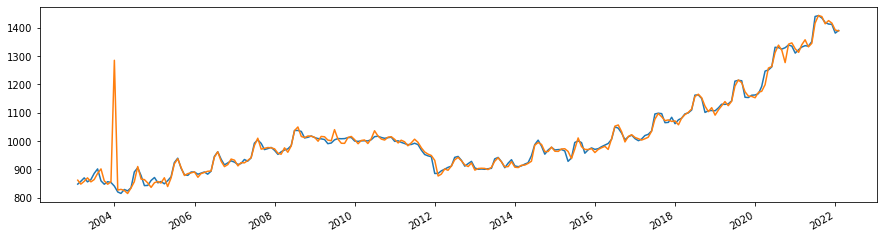

In [46]:
#Obtener mejor modelo de Arima
model7=auto_arima(ts[['Plantilla']], trace=True)

#Obtenemos modelo SARIMAX con parámetros obtenidos
params = model7.order 
sparams = model7.order+(12,) 
#freq MS quiere decir frecuencia mensual
smodel7 = SARIMAX(ts[['Plantilla']], 
                order=params,
                seasonal_order=sparams, 
                freq='MS'
                )
results7=smodel7.fit(maxiter=1000)

#hacemos una prediccion de todos los datos a partir de nuestro modelo
plt.plot(ts[['Plantilla']][1:])
y_pred_model7=results7.get_prediction(start='2003-02-01',end='2022-02-01').predicted_mean
y_pred_model7.plot()

#Evaluamos modelo Sarimax:
porc_error_SARIMAX=get_error_percentage(ts[['Plantilla']][1:],y_pred_model7)
f'El mejor modelo SARIMAX tiene unos parámetros de {sparams} y un porcentaje de error del {porc_error_SARIMAX}'

#### FbProphet

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


'El mejor modelo PROPHET tiene un porcentaje de error del 0.01707449110200554'

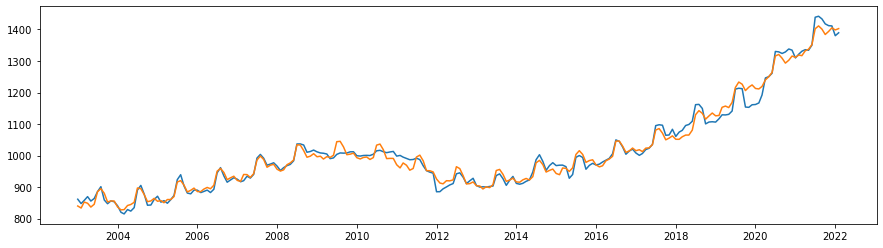

In [47]:
# Obtener modelo con Fbprophet
#instanciamos prophet
model8=Prophet() 
#transformación requerida
prf=ts[['Plantilla']].reset_index().rename(columns={'date':'ds','Plantilla':'y'}) 
#entrenamos modelo
model8.fit(prf)
#obtenemos valores de predicciones
yhat=model8.predict(prf).yhat
#creamos ts con valores predichos
y_pred_PF=pd.DataFrame({'y':yhat,
             'ds':pd.date_range(start='2003-01-01',
                                  end='2022-02-01',
                                  freq='MS')}).set_index('ds')
#dibujamos valores reales y predichos
plt.plot(ts[['Plantilla']])
plt.plot(y_pred_PF)

#Evaluamos modelo Prophet:
porc_error_PROPHET=get_error_percentage(ts[['Plantilla']],y_pred_PF)
f'El mejor modelo PROPHET tiene un porcentaje de error del {porc_error_PROPHET}'

### Casos_covid

In [48]:
#Importamos dataset casos covid
df_covid = pd.read_csv('data/casos_covid.csv', sep=',',encoding='latin1')

In [49]:
#transformación
df_covid['date']=df_covid.date.astype('datetime64[ns]')


#### Arima

In [50]:
ts_covid=df_covid.set_index('date')

In [51]:
#Obtener mejor modelo de Arima
model9=auto_arima(ts_covid, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=561.122, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=556.527, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=555.891, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=555.248, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=562.119, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=557.221, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=558.062, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=559.650, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=557.985, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.261 seconds


<AxesSubplot:>

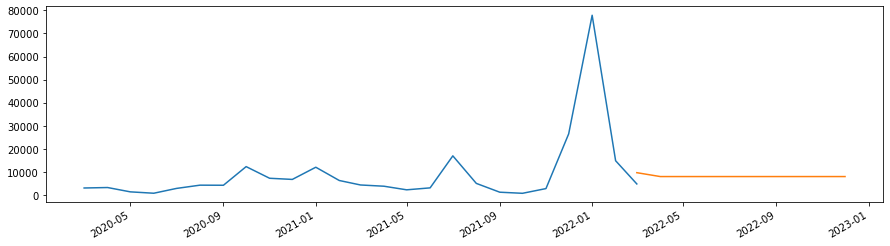

In [52]:
#creamos una serie para darle un indice
pred=model9.predict(n_periods=10)
plt.plot(ts_covid)
pd.Series(pred, index=pd.date_range(start='2022-03-01', end='2022-12-01', freq='MS')).plot()

#### FbProphet

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.


'El mejor modelo PROPHET tiene un porcentaje de error del 1.3185235696091734e-16'

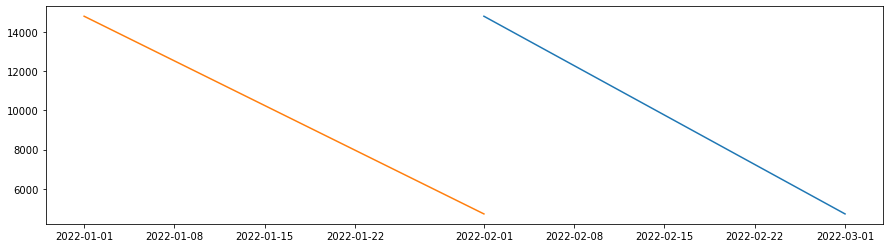

In [53]:
# Obtener modelo con Fbprophet
#instanciamos prophet
model9=Prophet(growth='linear') 
#transformación requerida
prf=ts_covid[-2:].reset_index().rename(columns={'date':'ds','numcasos':'y'})
#prf['cap']=78000
#entrenamos modelo
model9.fit(prf)
#obtenemos valores de predicciones
yhat=model9.predict(prf).yhat
#creamos ts con valores predichos
y_pred_PF=pd.DataFrame({'y':yhat,
             'ds':pd.date_range(start='2022-01-01',
                                  end='2022-02-01',
                                  freq='MS')}).set_index('ds')
#dibujamos valores reales y predichos
plt.plot(ts_covid[-2:])
plt.plot(y_pred_PF)

#Evaluamos modelo Prophet:
porc_error_PROPHET=get_error_percentage(ts_covid[-2:],y_pred_PF)
f'El mejor modelo PROPHET tiene un porcentaje de error del {porc_error_PROPHET}'


In [54]:
ds= pd.DataFrame({'ds':pd.date_range(start='2022-03-01',
                                  end='2022-12-01',
                                  freq='MS')})

In [55]:
model9.predict(ds).yhat

0     4722.0
1    -6422.5
2   -17207.5
3   -28352.0
4   -39137.0
5   -50281.5
6   -61426.0
7   -72211.0
8   -83355.5
9   -94140.5
Name: yhat, dtype: float64

In [56]:
#Conclusión => con los métodos que conocemos no es posible predicir la evolución de los datos covid

### Búsquedas Google

In [57]:
ts_google=ts[['busquedas_google']][32:] #desde septiembre de 2005

#### Autoarima

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1725.064, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1724.994, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1722.125, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1723.065, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1688.706, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1684.406, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1686.097, Time=0.30 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1688.330, Time=0.51 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1683.838, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1687.885, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1684.428, T

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


'El mejor modelo SARIMAX tiene unos parámetros de (1, 1, 2, 12) y un porcentaje de error del 0.5867782514631453'

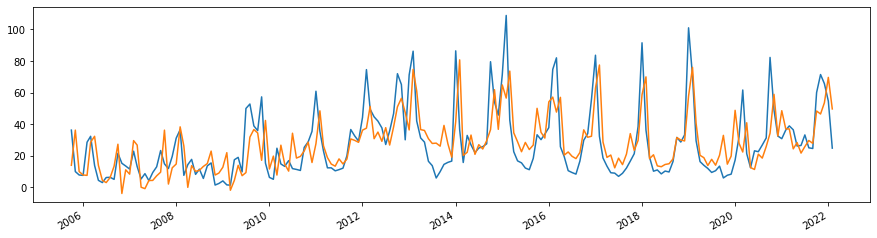

In [58]:
#Obtener mejor modelo de Arima
model10=auto_arima(ts_google, trace=True)

#Obtenemos modelo SARIMAX con parámetros obtenidos
params = model10.order 
sparams = model10.order+(12,) 
#freq MS quiere decir frecuencia mensual
smodel10 = SARIMAX(ts_google, 
                order=params,
                seasonal_order=sparams, 
                freq='MS'
                )
results10=smodel10.fit(maxiter=1000)

#hacemos una prediccion de todos los datos a partir de nuestro modelo
plt.plot(ts_google[1:])
y_pred_model10=results10.get_prediction(start='2005-10-01',end='2022-02-01').predicted_mean
y_pred_model10.plot()

#Evaluamos modelo Sarimax:
porc_error_SARIMAX=get_error_percentage(ts_google[1:],y_pred_model10)
f'El mejor modelo SARIMAX tiene unos parámetros de {sparams} y un porcentaje de error del {porc_error_SARIMAX}'

#### FbProphet

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


'El mejor modelo PROPHET tiene un porcentaje de error del 0.6262115721945032'

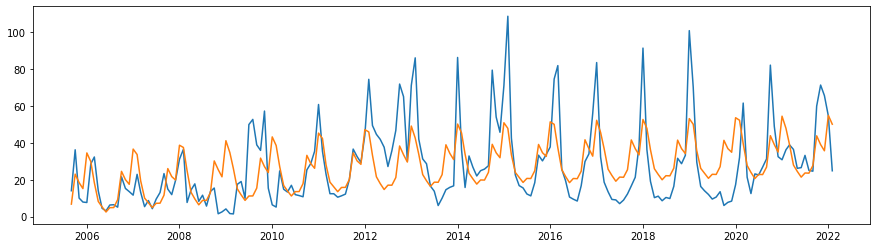

In [59]:
# Obtener modelo con Fbprophet
#instanciamos prophet
model11=Prophet() 
#transformación requerida
prf=ts_google.reset_index().rename(columns={'date':'ds','busquedas_google':'y'}) 
#entrenamos modelo
model11.fit(prf)
#obtenemos valores de predicciones
yhat=model11.predict(prf).yhat
#creamos ts con valores predichos
y_pred_PF=pd.DataFrame({'y':yhat,
             'ds':pd.date_range(start='2005-09-01',
                                  end='2022-02-01',
                                  freq='MS')}).set_index('ds')
#dibujamos valores reales y predichos
plt.plot(ts_google)
plt.plot(y_pred_PF)

#Evaluamos modelo Prophet:
porc_error_PROPHET=get_error_percentage(ts_google,y_pred_PF)
f'El mejor modelo PROPHET tiene un porcentaje de error del {porc_error_PROPHET}'

## Exportar modelos

Decidimos exportar el terce modelo con mejor score (smodel4) porque evita tener que predecir la variable exógena "casos_covid".

Para usar el modelo debemos exportar:
* Modelo ARIMA 
* Modelo Prophet para predecir variable exógena de Plantilla
* Modelo ARIMA para predecir variable de búsquedas google
* Dataset con datos históricos para entrenas modelos ARIMA

In [60]:
import pickle

In [61]:
#Exportamos el mejor modelo (a pesar de no poder predecir bien los casos covid)
with open('models/model_enfermeras_covid.pkl','wb') as f:
    pickle.dump(model1,f)

In [62]:
#Exportamos el segundo mejor modelo porque éste no requiere predecir los casos covid
with open('models/model_enfermeras.pkl','wb') as f:
    pickle.dump(model2,f)

In [63]:
#Modelo Prophet para predecir variable exógena de Plantilla
with open('models/model_enfermeras_plantilla.pkl','wb') as f:
    pickle.dump(model8,f)

In [64]:
#Modelo Arima para predecir variable exógena de búsquedas_google
with open('models/model_enfermeras_google.pkl','wb') as f:
    pickle.dump(model10,f)

## Otros

In [65]:
#Exportamos el model sin tener en cuenta la pandemia
#with open('models/model_enfermeras_sin_covid.pkl','wb') as f:
#    pickle.dump(smodel10,f)

In [66]:
ts_it.tail(12) #las predicciones con pandemia me salen disparadas

,Plantilla_de_baja
date,
2021-03-01,77.846129
2021-04-01,77.978333
2021-05-01,68.478065
2021-06-01,67.994333
2021-07-01,73.054194
2021-08-01,62.301290
2021-09-01,59.239667
2021-10-01,65.073548
2021-11-01,65.600333


In [67]:
#Exportamos el tercer mejor modelo Arima porque éste no requiere predecir los casos covid sin entrenar
#with open('models/model_enfermeras2.pkl','wb') as f:
 #   pickle.dump(model3,f)

In [68]:
#Exportamos el tercer mejor modelo Arima porque éste no requiere predecir los casos covid sin entrenar
#with open('models/model_enfermeras3.pkl','wb') as f:
#    pickle.dump(model3b,f)